# Final Project: 
# Rating Prediction & Recommendation Analysis for Restaurants on Yelp

Team: Jiaying Wu, Chen Li, Zhao Chen

# Project Outline

1. Objective
2. EDA
3. Methods and Findings

   -Regression: Lasso, RandomForest,Xgboost and Neural Network

   -Recommender System: SVD, Content filtering

   -Sentiment Analysis: NLP

4. Conclusions

## 1. Objective: 
Our team is interested in applying what we have learned in the machine learning class on the Yelp restaurant data and identifying the best model to predict restaurant ratings and test the recommendation generated by these models. 

## 2. Exploratory Data Analysis (EDA)
We extracted 3 datasets (business, user and review) with total volume of ~10 GB from Yelp Open Source Dataset (https://www.yelp.com/dataset/documentation/main). The data was originally in JSON format and later converted into csv format.


Transformation for the 3 datasets is conducted via filtering the data using the constraints below:

1) Select restaurants that are open

2) Narrow down the time span of the data collection to the intervel between January 2020 and January 2021

3) Include all 26 predictors (columns)

4) Pick 10000 observations randomly.


Lastly, the 3 transformed datasets are merged into one csv file and uploaded to GitHub for the following data analysis.


In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, lasso_path, LassoCV)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#content
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

#nlp
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

#knn
from surprise.prediction_algorithms import knns
from surprise import KNNBasic
from surprise.similarities import cosine, msd, pearson

# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import re

#deep learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#map
import folium 

#preprocessing 
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

#plot
sns.set_theme(style="whitegrid", palette="pastel")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenzhaograce/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Read csv file 
yelp=pd.read_csv("https://raw.githubusercontent.com/chenzhaograce/MAS651/main/yelp_restaurant_review.csv")

In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   review_id                10000 non-null  object 
 1   user_id                  10000 non-null  object 
 2   business_id              10000 non-null  object 
 3   text                     10000 non-null  object 
 4   useful                   10000 non-null  int64  
 5   stars                    10000 non-null  int64  
 6   funny                    10000 non-null  int64  
 7   cool                     10000 non-null  int64  
 8   date                     10000 non-null  object 
 9   user_review_count        10000 non-null  int64  
 10  yelping_since            10000 non-null  int64  
 11  user_useful              10000 non-null  int64  
 12  user_funny               10000 non-null  int64  
 13  user_cool                10000 non-null  int64  
 14  elite                  

### 2.1 Where are the restaurants located?

In [5]:
from folium.plugins import HeatMap,MarkerCluster

m1=folium.Map(location = (37,-95),
              max_zoom=12,min_zoom=4,zoom_start=6,
              tiles='open street map')

locations = yelp[['latitude','longitude']]
cluster = MarkerCluster(locations=locations,
                       ).add_to(m1)
    
m1

Since we did not specify the city and states in the Yelp dataset, we can see that the locations of the restuarant are scattered all around the United States.

### 2.2 What is the distribution of restaurant stars/ratings?

Text(0.5, 1.0, 'Distribution of Restaurant Ratings')

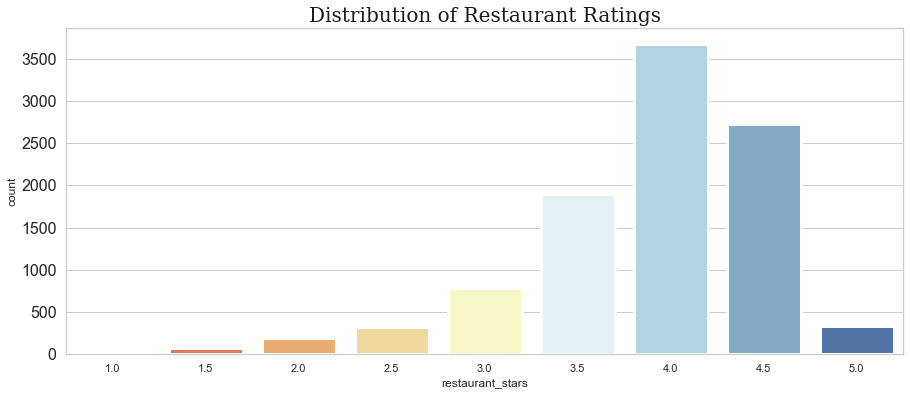

In [ ]:
#distribution of stars 
fig,ax= plt.subplots(figsize=(15,6))
plt.yticks(fontsize=16)


sns.countplot(x="restaurant_stars",
              data=yelp,
              palette="RdYlBu",
              linewidth=3)



plt.title("Distribution of Restaurant Ratings",
          font="Serif",
          size=20,color='k')



This histogram plot shows the distribution of the restuarant rating that is the average ratings calculated using all the existing restuarants' rating records. The distribution pattern is a left skew. A big number of rating counts is centered at rating level of 4.0.

### 2.3 What is the distribution of user ratings?

Text(0.5, 1.0, 'Distribution of User Review Ratings')

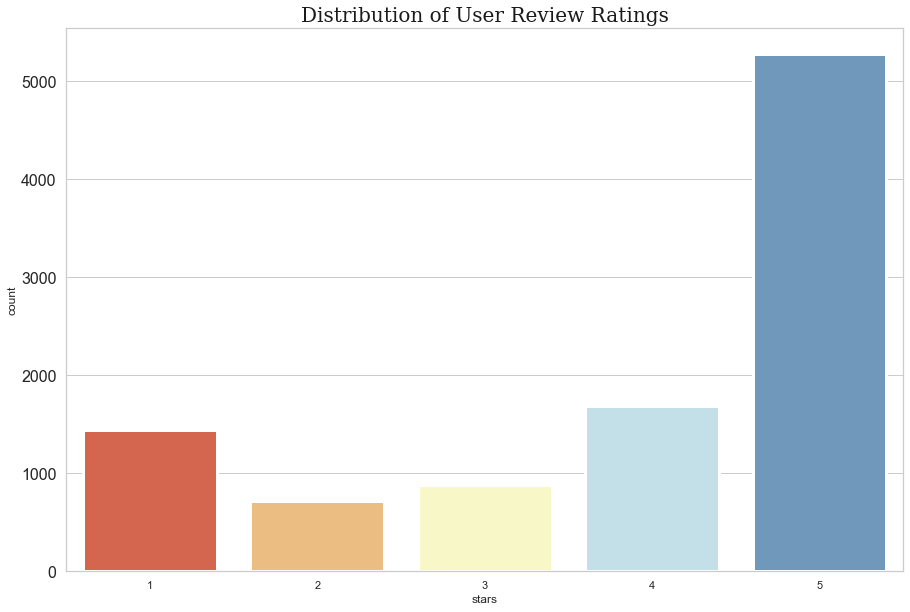

In [ ]:
fig,ax= plt.subplots(figsize=(15,10))
plt.yticks(fontsize=16)


sns.countplot(x="stars",
              data=yelp,
              palette="RdYlBu",
              linewidth=3)

plt.title("Distribution of User Review Ratings",
          font="Serif",
          size=20,color='k')


We generated this barplot to reflect the distribution of user's review ratings documented in the original dataset with 200000 users' records included. The left-skewed distribution shows that users' rating at level 5 has the highest count.

### 2.4 How is the average ratings of our selected users distributed?

Text(0.5, 1.0, 'Average Rating of Users')

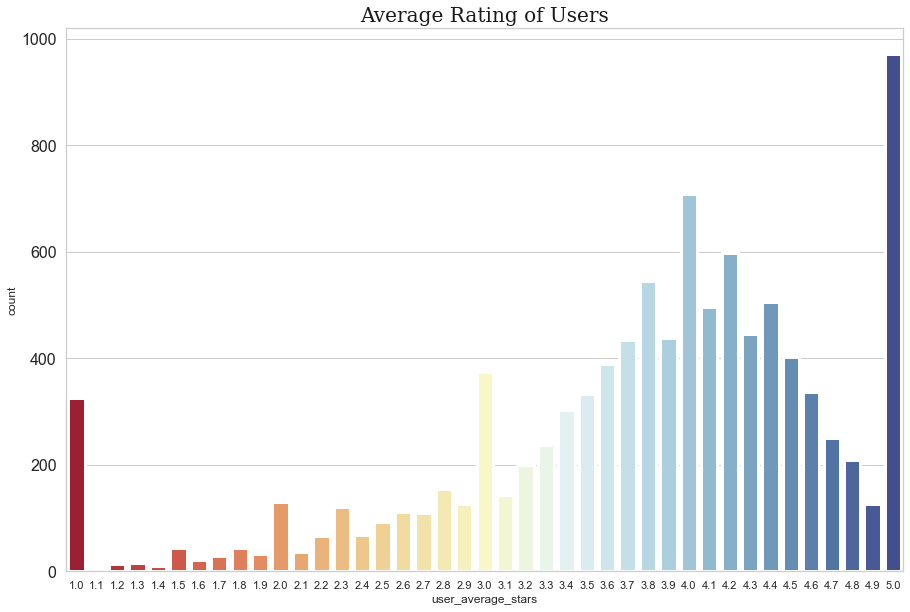

In [ ]:
fig,ax= plt.subplots(figsize=(15,10))
plt.yticks(fontsize=16)


sns.countplot(x=yelp.user_average_stars.round(decimals=1),
              palette="RdYlBu",
              linewidth=3)

plt.title("Average Rating of Users",
          font="Serif",
          size=20,color='k')


This histogram shows the distribution of the average ratings based on the records of the 10000 randomly selected users in the data set. The distribution is left skewed with rating counts centred in the range of 3.5-4.5. Notably high numbers of counts in average ratings at 1.0, 3.0, and 5.0 is also observed. 

### 2.5 How long have these users been using yelp?

Text(0.5, 1.0, 'Yelp users count over years')

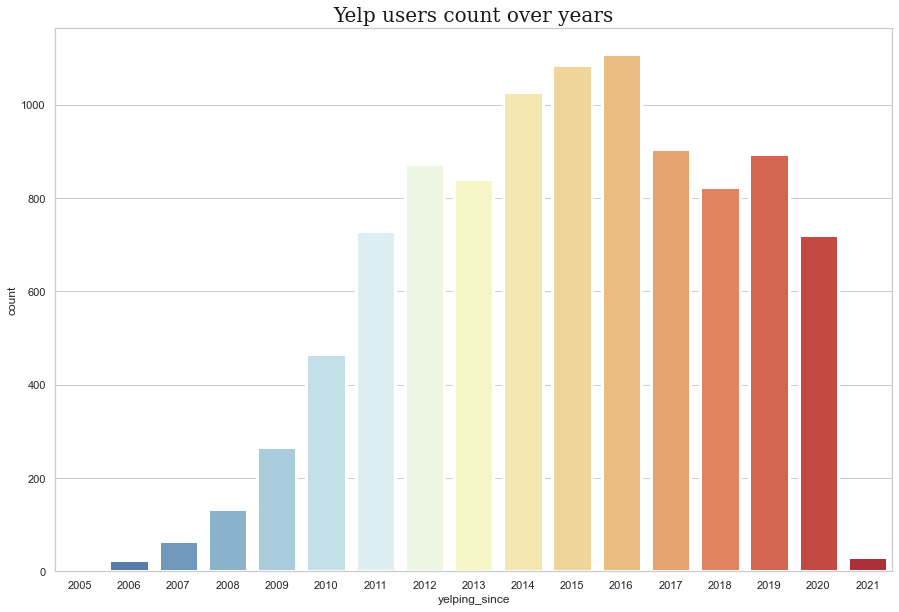

In [ ]:
fig,ax= plt.subplots(figsize=(15,10))

sns.countplot(x=yelp.yelping_since,
              palette="RdYlBu_r",
              linewidth=3)

plt.title("Yelp users count over years",
          font="Serif",
          size=20,color='k')


The number of Yelp users increased significantly after 2008 and reached its maximum in 2016 then followed by a decreasing trend. The number of users experienced a dramatic drop in 2021. This is because we only included the data of January 2021 in the analysis. 

### 2.6 Reviews marked as useful, cool and funny

In [ ]:
useful_review=yelp['useful'][yelp['useful']==1].count()
cool_review=yelp['cool'][yelp['cool']==1].count()
funny_review=yelp['funny'][yelp['funny']==1].count()

Text(0.5, 1.0, 'review_marks')

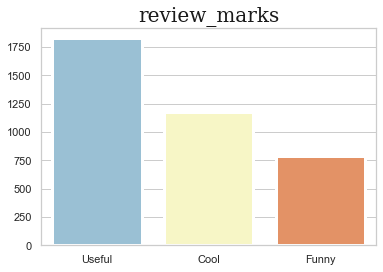

In [ ]:
x=['Useful','Cool','Funny']
y=[useful_review,cool_review,funny_review]
sns.barplot(x,y,
            palette="RdYlBu_r",
            linewidth=3)

plt.title("review_marks",
          font="Serif",
          size=20,color='k')


There are three categories of review_marks we included in the analysis. They are 'Useful','Cool' and 'Funny'. The review makrs of 'Useful' is characterized by the highest number of counts among the three, and 'Funny' category has the lowest number of counts.

### 2.7 Data Cleaning & Feature Engineering

In [ ]:
yelp1=yelp.drop(['elite','attributes','latitude','longitude','city','state','name'],axis=1)
yelp1["date"] = pd.to_datetime(yelp1['date'])
yelp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                10000 non-null  object        
 1   user_id                  10000 non-null  object        
 2   business_id              10000 non-null  object        
 3   text                     10000 non-null  object        
 4   useful                   10000 non-null  int64         
 5   stars                    10000 non-null  int64         
 6   funny                    10000 non-null  int64         
 7   cool                     10000 non-null  int64         
 8   date                     10000 non-null  datetime64[ns]
 9   user_review_count        10000 non-null  int64         
 10  yelping_since            10000 non-null  int64         
 11  user_useful              10000 non-null  int64         
 12  user_funny               10000 no

- Elite column has above 75% nulls and attributes have too many (above 40) different values, which is hard to be used in predictors. We delete the two columns.
- Date column should be transformed to datetime format. And we also want a time span from user registration time to the review time.

In [ ]:
yelp1['year']=yelp1['date'].dt.year
yelp1['year'].astype('int64')
yelp1['review_over_register']=yelp1["year"] - yelp1['yelping_since']

In [ ]:
yelp.head(5)

review_id                 user_id             business_id  \
0  LF75luO0JCSYQHmRXWSd1Q  Jjeuks554V_DBHQ2-PLtkA  4SOaSFKdmneYwl0ZtLiuIQ   
1  VnfBcifzjQj5uM9YxwObTw  Jjeuks554V_DBHQ2-PLtkA  mP1EdIafQKMuOm9O4PzAfA   
2  1GOLhWkXEbdkfKqyVRK9pw  CoJ5LKzaTcB5J1FFj4wiMQ  mP1EdIafQKMuOm9O4PzAfA   
3  0H9ixmAIhBEyt1MCYQ_zHw  3mC9a3T9evciqNIhD-SDEw  5-nUL-_CTYIzya5WG7bf5A   
4  pEOS7VTXHe7ZSLji3BHVmQ  MxvC-asktccrSrA6rq7XUA  5-nUL-_CTYIzya5WG7bf5A   

                                                text  useful  stars  funny  \
0  I'm starting to feel like Norm from Cheers at ...       0      5      0   
1  We had such a fabulous experience at Barcelona...       0      5      0   
2  I recently went to Barcelona for the first tim...       0      4      0   
3  It's just gourmet McDonalds. Don't make a spec...       0      3      0   
4  I mean if you are a burger  connoisseur like m...       0      4      0   

   cool                 date  user_review_count  ...  user_average_stars  \
0     0  2020-09-08 19:18:39                 29  ...                4.88   
1     1  2020-07-19 01:40:36                 29  ...                4.88   
2     0  2020-02-11 23:37:58                  3  ...                4.67   
3     0  2020-01-05 23:31:10                  1  ...                3.00   
4     0  2020-10-23 13:59:48                110  ...                4.03   

                               name   latitude  longitude       city  state  \
0  The Arlington Restaurant & Diner  42.403962 -71.140326  Arlington     MA   
1      Barcelona Wine Bar South End  42.344936 -71.070544     Boston     MA   
2      Barcelona Wine Bar South End  42.344936 -71.070544     Boston     MA   
3                        H&F Burger  33.771797 -84.365840    Atlanta     GA   
4                        H&F Burger  33.771797 -84.365840    Atlanta     GA   

   restaurant_stars                                         categories  \
0               3.0            Diners, Restaurants, Breakfast & Brunch   
1               4.5  Spanish, Bars, Tapas Bars, Wine Bars, Tapas/Sm...   
2               4.5  Spanish, Bars, Tapas Bars, Wine Bars, Tapas/Sm...   
3               3.5       Restaurants, Burgers, American (Traditional)   
4               3.5       Restaurants, Burgers, American (Traditional)   

   restaurant_review_count                                         attributes  
0                      135  {'RestaurantsGoodForGroups': 'True', 'Business...  
1                     1097  {'Smoking': "u'no'", 'Caters': 'True', 'BestNi...  
2                     1097  {'Smoking': "u'no'", 'Caters': 'True', 'BestNi...  
3                      468  {'OutdoorSeating': 'False', 'GoodForKids': 'Tr...  
4                      468  {'OutdoorSeating': 'False', 'GoodForKids': 'Tr...  

[5 rows x 26 columns]

In [ ]:
print('business_id unique value:',len(yelp1['business_id'].unique()))
print('user_id unique value:',len(yelp1['user_id'].unique()))
print('review_id unique value:',len(yelp1['review_id'].unique()))

business_id unique value: 6815
user_id unique value: 9332
review_id unique value: 10000


In [ ]:
yelp1.corr().style.background_gradient(cmap='Blues')

## 3. Model Building-Regression

First, we consider the response as regression problem. And prepared for the train and test set for later use.

- stars is the response value, and all the others are the predictors. (We'll keep the date and text first)

In [ ]:
# Make all features predict if the song was liked or not
X = yelp1.drop(['stars','text','year','date','review_id','business_id','user_id','categories','yelping_since'], axis=1)
# Feature to predict on
y = yelp1['stars']
#Seperate the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
X.columns

Index(['useful', 'funny', 'cool', 'user_review_count', 'user_useful',
       'user_funny', 'user_cool', 'fans', 'user_average_stars',
       'restaurant_stars', 'restaurant_review_count', 'review_over_register'],
      dtype='object')

- We included 12 variables as predictors, with names as follows: 'useful',  'funny', 'cool', 'user_review_count', 'user_useful', 'user_funny', 'user_cool', 'fans', 'user_average_stars','restaurant_stars', 'restaurant_review_count', 'review_over_register'

### 3.1 Random Forest

We first use the Random Forest model to predict the star ratings with the 12 predictors in the training set.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Make a random forest classifier
model1 = RandomForestRegressor(n_estimators=100,random_state=1)
model1.fit(X, y)
predictions = model1.predict(X_test)

In [ ]:
y_pred = model1.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.398402


In [ ]:
print("acuracy score: %f" % r2_score(y_test,y_pred))

acuracy score: 0.928698


The RMSE of the predicted value is as low as 0.4 star compared with the true value.

The R-square value is as high as 0.93.

Both of the two results indicate good predicting ability of the model. 

Thus, the Random Forest model works pretty well.


### 3.2 Xgboost


We also use the Xgboost model and the GridSearchCV package to test different combinations of parameters and to predict the star ratings based on the 12 predictors. 

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500,1000],
           'colsample_bylevel': [0.5, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
#negtavie: maximize the negative means minimize the sqrt
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bylevel': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  1.0482825797931028


In [ ]:
y_pred2 = clf.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred2))
print("RMSE: %f" % (rmse))

RMSE: 1.027129


In [ ]:
print("acuracy score: %f" % r2_score(y_test,y_pred2))

acuracy score: 0.526074


The RMSE of the predicted value is as high as 1.03 stars compared with the true value, while the whole range of the star ratings is only from 1 to 5, indicating a large error in prediction.

The R-square value is as low as 0.53, indicating the model has not enough accuracy to predict the real ratings.

Thus, the the prediction results from this Xgboost model is not satisfactory.

### 3.3 Lasso

We also use the Lasso model to find the optimal lambda parameter and to predict the ratings based on the 12 predictors.

In [ ]:
# Train Lasso model
lasso = Lasso(alpha=0.2, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train, y_train)

lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = X_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)
 
print(lasso_coeff)

                    Columns  Coefficient Estimate
0                    useful                   0.0
1                     funny                   0.0
2                      cool                   0.0
3         user_review_count                   0.0
4               user_useful                   0.0
5                user_funny                   0.0
6                 user_cool                   0.0
7                      fans                   0.0
8        user_average_stars                   0.0
9          restaurant_stars                   0.0
10  restaurant_review_count                   0.0
11     review_over_register                   0.0


In [ ]:
from sklearn.metrics import mean_squared_error

## Lasso with 10-fold cross-validation

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
## print the best choice of the tunin parameter
print("Alpha=", lassocv.alpha_)


Alpha= 1.2695426531002295e-05


In [ ]:
## Use the chosen tuning paramter for the final model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)

best model coefficients:


useful                    -0.096152
funny                     -0.129791
cool                       0.180363
user_review_count          0.000018
user_useful                0.000000
user_funny                 0.000035
user_cool                 -0.000031
fans                      -0.000016
user_average_stars         0.854081
restaurant_stars           0.627208
restaurant_review_count    0.000032
review_over_register       0.007414
dtype: float64

In [ ]:
y_pred3 = lasso.predict(X_test)
 
# Calculate Mean Squared Error
rmse=np.sqrt(mean_squared_error(y_test, y_pred3))
print("RMSE :", rmse)

RMSE : 1.0557097842312217


In [ ]:
print("acuracy score: %f" % r2_score(y_test,y_pred3))

acuracy score: 0.499332


The RMSE of the predicted value is as high as 1.06 stars compared with the true value, indicating a large error in prediction.

The R-square value is as low as 0.50, indicating the model has not enough accuracy to predict the real ratings.

Thus, the the prediction results from this Lasso model is not satisfactory.

### 3.4 Neural networks

We create a neural network with 4 layers to predict the star ratings. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
# define the keras model
model2 = Sequential()
model2.add(Dense(12, input_dim=12, activation='relu')) 
model2.add(Dense(8, activation='relu'))
model2.add(Dense(16, activation="relu"))
model2.add(Dense(1, activation="linear"))
model2.compile(optimizer="Adam", loss='mean_squared_error', metrics=['mse'])
print(model2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 12)                156       
                                                                 
 dense_21 (Dense)            (None, 8)                 104       
                                                                 
 dense_22 (Dense)            (None, 16)                144       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit the keras model on the training data
model2.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
800/800 [==============================] - 1s 1ms/step - loss: 3.0973 - mse: 3.0973
Epoch 2/50
800/800 [==============================] - 1s 1ms/step - loss: 1.2838 - mse: 1.2838
Epoch 3/50
800/800 [==============================] - 1s 973us/step - loss: 1.1872 - mse: 1.1872
Epoch 4/50
800/800 [==============================] - 1s 969us/step - loss: 1.1583 - mse: 1.1583
Epoch 5/50
800/800 [==============================] - 1s 1ms/step - loss: 1.1337 - mse: 1.1337
Epoch 6/50
800/800 [==============================] - 1s 991us/step - loss: 1.1204 - mse: 1.1204
Epoch 7/50
800/800 [==============================] - 1s 1ms/step - loss: 1.1372 - mse: 1.1372
Epoch 8/50
800/800 [==============================] - 1s 986us/step - loss: 1.1067 - mse: 1.1067
Epoch 9/50
800/800 [==============================] - 1s 989us/step - loss: 1.1047 - mse: 1.1047
Epoch 10/50
800/800 [==============================] - 1s 993us/step - loss: 1.1046 - mse: 1.1046
Epoch 11/50
800/800 [================

In [ ]:
# evaluate the model
_, accuracy = model2.evaluate(X_test, y_test)
np.sqrt(accuracy)

63/63 [==============================] - 0s 1ms/step - loss: 1.1022 - mse: 1.1022


1.0498522654552955

In [ ]:
prediction=model2.predict(X_test)

In [ ]:
print("acuracy score: %f" % r2_score(y_test,prediction))

acuracy score: 0.501880


The RMSE of the predicted value is as high as 1.05 stars compared with the true value, indicating a large error in prediction.

The R-square value is as low as 0.50, indicating the model has not enough accuracy to predict the real ratings.

Thus, the prediction results from this created neural network is not satisfactory.

## Model Building - Recommendation system

### 3.5 Collaborative filtering using SVD Surprise
We separate the data into train and test data and load the data into surprise library. And we use 5 factors and 200 epochs to fit the data.

In [ ]:
yelp2=yelp[['user_id','business_id','date','stars']]

In [ ]:
# Split data in training and test
train_data, test_data = train_test_split(yelp2, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (8000, 4)
Test size: (2000, 4)


In [ ]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(yelp2[['user_id','business_id','stars']], reader)
data_test = Dataset.load_from_df(yelp2[['user_id','business_id','stars']], reader)

In [ ]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [ ]:
mean1 = data_train.global_mean
print('Train rating', mean1)

Train rating 3.8642


In [ ]:
mean2 = data_test.global_mean
print('Test rating', mean2)

Test rating 3.8642


In [ ]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [ ]:
# Create SVD algorithm with 5 factors
k_factors = 5
algo = SVD(n_factors= k_factors, n_epochs= 200, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01)

In [ ]:
# Train the algorithm on the trainset
algo.fit(data_train)

In [ ]:
# Calculate RMSE for training dataset
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.3179


0.3179128763753145

In [ ]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.3179


0.3179128763753145

In [ ]:
train_data.head(5)

user_id             business_id                 date  \
4869  bHcx-zyfsmWbjgAdcqy7rQ  mQ2nucaUzG5fhuMl7tceAA  2020-10-08 20:02:23   
7342  Ii3unHfw-hursXf88aMZ6w  rxb9qD53hi8HkR_L8MONRw  2020-06-09 21:20:39   
2783  h4WjLil1FXeMxy9xtURf8Q  ouid7BM2LlujXJK-FJ62zQ  2020-10-30 20:10:45   
4736  rG2pxZWDJfzZ5L3JFu2O1w  fd3yGJTbSviei1TFgHGXUw  2020-01-31 14:34:22   
1710  hAhxZjIbAZWRFEBy7xY20w  oXkUtWk-TR4QpSmAcKE93A  2020-08-03 11:54:44   

      stars  
4869      4  
7342      1  
2783      5  
4736      5  
1710      2

In [ ]:
# Prediction without real rating
p1 = algo.predict(uid = train_data.iloc[0].user_id, iid = train_data.iloc[0].business_id, verbose = True)

user: bHcx-zyfsmWbjgAdcqy7rQ item: mQ2nucaUzG5fhuMl7tceAA r_ui = None   est = 3.98   {'was_impossible': False}


We test the first line of our train data, the rating result is 3.98, which is really close to our original values.

### 3.6 Content-based recommenations
Concerning the content-based recommendations, we only use 2 predictors-'name' and 'test'. The algorithms we use si tfidfvectorizer. And we use cosine-similarity to build the model.

In [ ]:
yelp3=yelp[['name','text']]

In [ ]:
yelp3.head(5)

name  \
0  The Arlington Restaurant & Diner   
1      Barcelona Wine Bar South End   
2      Barcelona Wine Bar South End   
3                        H&F Burger   
4                        H&F Burger   

                                                text  
0  I'm starting to feel like Norm from Cheers at ...  
1  We had such a fabulous experience at Barcelona...  
2  I recently went to Barcelona for the first tim...  
3  It's just gourmet McDonalds. Don't make a spec...  
4  I mean if you are a burger  connoisseur like m...

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(yelp3['text'])
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [ ]:
tfidf_matrix.shape

(10000, 662639)

#### Calculate cosine similarity

In [ ]:
# calculating cosine similarity between items
 
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_similarities.shape

(10000, 10000)

In [ ]:
cosine_similarities

array([[1.00000000e+00, 8.55838672e-03, 6.84239298e-03, ...,
        1.02522075e-02, 1.12249830e-03, 0.00000000e+00],
       [8.55838672e-03, 1.00000000e+00, 1.38218380e-02, ...,
        7.63794156e-03, 6.86955960e-04, 0.00000000e+00],
       [6.84239298e-03, 1.38218380e-02, 1.00000000e+00, ...,
        5.05829419e-03, 7.18127985e-04, 3.42213829e-03],
       ...,
       [1.02522075e-02, 7.63794156e-03, 5.05829419e-03, ...,
        1.00000000e+00, 2.13618113e-02, 0.00000000e+00],
       [1.12249830e-03, 6.86955960e-04, 7.18127985e-04, ...,
        2.13618113e-02, 1.00000000e+00, 2.78578188e-03],
       [0.00000000e+00, 0.00000000e+00, 3.42213829e-03, ...,
        0.00000000e+00, 2.78578188e-03, 1.00000000e+00]])

In [ ]:
cosine_similarities[0].argsort()

array([9999, 3263, 3262, ..., 2382, 7152,    0])

In [ ]:
## find the top 99 highest cosine similarities
cosine_similarities[0].argsort()[:-100:-1]

array([   0, 7152, 2382, 4106, 3441, 4969, 2597, 7729, 5868,  544, 5672,
       4527, 5143, 4881, 7465, 9335, 5980,  300, 8423, 3606,  204, 7543,
       7632,  508, 4558, 8694, 1732, 8000, 6004, 2812, 7476, 3077, 2744,
       9164, 7038,  104, 1518, 4124, 5870, 7277, 3402, 7827, 1827, 7268,
       5547, 6867, 1284,  331, 5481, 8538, 3170, 5020, 1040, 7296,  785,
       7670, 7634, 2703, 5694, 1885, 3976,  714,  914,  473, 2056, 4328,
       2006, 1973, 3134, 5697, 7273,   78, 6507, 8026, 7155, 8188, 7183,
       7538, 1014, 8975, 3580, 2109,  224, 1758, 2352,  751, 1919, 7040,
        834, 7017, 6412, 5017, 3041, 8252, 3547, 4104, 6180, 4234, 4733])

In [ ]:
##  when you do a[::-1], it starts from the end towards the first taking each element. So it reverses a.

results = {}

for idx, row in yelp3.iterrows():
    ## find the top 99 highest cosine similarities
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    ## the the items corresponding to the highest similarities
    similar_items = [(cosine_similarities[idx][i], yelp3['name'][i]) for i in similar_indices]

    results[row['name']] = similar_items[1:]
    
print('done!')
type(results)

done!


dict

#### Make recommendation

In [ ]:
results['Shake Shack'][:15]

[(0.06909561387261358, 'Sushi Junai Omakase'),
 (0.04956759746472205, 'The Buzz Mill'),
 (0.04584099669320011, 'Chipotle Mexican Grill'),
 (0.04277084364072023, 'The Bagel Table'),
 (0.04255311963108395, 'Fat City Café'),
 (0.038384988654858614, 'Pluckers Wing Bar - The Linc'),
 (0.037830174529885845, 'Panda Express'),
 (0.035397512927472556, 'Pluckers Wing Bar - South Lamar'),
 (0.034053925093172115, "P. Terry's Burger Stand"),
 (0.03283677354414676, 'Taco Cabana'),
 (0.03272055458463877, 'Eight Sushi Lounge'),
 (0.032305382611259585, 'Row 34'),
 (0.0305245628333405, 'The King Crab Shack'),
 (0.029399544303611157, "Jimmy V's Grill & Pub"),
 (0.02937760863608089, 'Panera Bread')]

We choose the restaurant -'Shake Shack' to predict the top 15 restaurants which are similar to it with cosine similarity. And the result is quite match our intuition. Since 'Shake Shack' is a popular fast food restaurant and we can find there are similarities in the results like panda express and taco cabana.

### 3.7 NLP-sentimental analysis
This part is a bonus part to explore if we can use only the text column to find out the sentiment from users. What we use for this part is nltk.download('vader_lexicon'). We analyze the results from the package and use SentimentIntensityAnalyzer to find out three sentiments including neutral, positive and negative. 

- Resources: https://thecleverprogrammer.com/2021/07/03/hotel-reviews-sentiment-analysis-with-python/

In [ ]:
sentiments = SentimentIntensityAnalyzer()
yelp["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in yelp["text"]]
yelp["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in yelp["text"]]
yelp["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in yelp["text"]]
print(yelp.head())

                review_id                 user_id             business_id  \
0  LF75luO0JCSYQHmRXWSd1Q  Jjeuks554V_DBHQ2-PLtkA  4SOaSFKdmneYwl0ZtLiuIQ   
1  VnfBcifzjQj5uM9YxwObTw  Jjeuks554V_DBHQ2-PLtkA  mP1EdIafQKMuOm9O4PzAfA   
2  1GOLhWkXEbdkfKqyVRK9pw  CoJ5LKzaTcB5J1FFj4wiMQ  mP1EdIafQKMuOm9O4PzAfA   
3  0H9ixmAIhBEyt1MCYQ_zHw  3mC9a3T9evciqNIhD-SDEw  5-nUL-_CTYIzya5WG7bf5A   
4  pEOS7VTXHe7ZSLji3BHVmQ  MxvC-asktccrSrA6rq7XUA  5-nUL-_CTYIzya5WG7bf5A   

                                                text  useful  stars  funny  \
0  I'm starting to feel like Norm from Cheers at ...       0      5      0   
1  We had such a fabulous experience at Barcelona...       0      5      0   
2  I recently went to Barcelona for the first tim...       0      4      0   
3  It's just gourmet McDonalds. Don't make a spec...       0      3      0   
4  I mean if you are a burger  connoisseur like m...       0      4      0   

   cool                 date  user_review_count  ...  longitude     

In [ ]:
x = sum(yelp["Positive"])
y = sum(yelp["Negative"])
z = sum(yelp["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [ ]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  2171.6879999999996
Negative:  439.4619999999986
Neutral:  7388.889


- Summary:
Thus, according to the above results, more than 7300 reviews are classified as neutral, more than 2100 reviews are classified as positive. So it can be said that people are really happy with the services of the hotels they have stayed in as the negative reviews are below 450.

In [ ]:
nlp = {'Negative': y, 'Neutral': z, 'Positive': x}
nlp = pd.DataFrame(pd.Series(nlp),columns=['num'])
 
nlp=nlp.reset_index().rename(columns={'index': 'sentiment'})

Text(0.5, 1.0, 'Sentiment_lables')

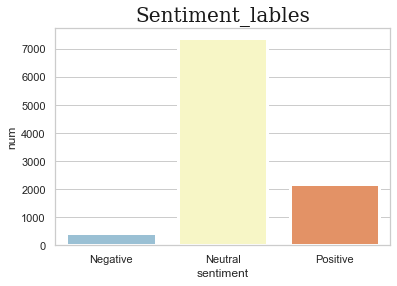

In [ ]:
sns.barplot(x='sentiment',y='num',data=nlp,
            palette="RdYlBu_r",
            linewidth=3)

plt.title("Sentiment_lables",
          font="Serif",
          size=20,color='k')


From the result, we can find that the neutral sentiment accounts for the highest part. And it is not similar to the individual's rating. So the sentiment analysis has no direct relation with the rating distribution.

## 4. Conclusion:
- Under the **category of regression analysis**, the **Random Forest model** using 12 predictors performs the best (RMSE=0.39) when predict ratings.

- Under the **category of recommender system analysis**, the **SVD model** based on the collaborative filtering method using 3 predictors shows an even improved performance (RMSE=0.32).

- The **content-filtering based model** produced recommendations that **well match up with our intuition**.

- **Sentiment analysis using NLP** shows a very **different results** compared to the true observation of the rating distribution.


### 4.1 Business Insights:
- If we wish to **predict the potential ratings** from a customer for a specific restaurant when predictor information is given, the **Random Forest model** and **SVD model** could work well. 

- If we have the descriptions of the restaurants, we could use the **content-filtering-based model**  to **offer suggestion for customers** who look for similar favorite restaurants. 

- For the **NLP model**, its results may **not be proper to be used in restaurant recommendation**. Further investigation of this method is needed.